In [15]:
# Import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import re
import requests
from datetime import datetime

In [16]:
# path to your specola database archive csv file, for more info visit:
# https://sunspots.irsol.usi.ch/db/choose-dl-year.php
specola_data_csv_file_path = './sunspot_data_excel.csv'

df = pd.read_csv(specola_data_csv_file_path)

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# print the head to verify pandas is reading the file correctly
df.head()

,date,time,group nr.,weighted spot count,type,latitude,longitude
0,6/1/1957,7:55,275,2,J,-10.1,179.9
1,6/1/1957,7:55,278,19,H,21.4,157.9
2,6/1/1957,7:55,281,28,C,-22.5,129.8
3,6/1/1957,7:55,286,6,B,19.3,171.3
4,6/1/1957,7:55,288,15,C,-22.5,92.2


In [23]:
solar_maximum_years = [1958,1968,1980, 1990, 2001, 2014]
solar_minimum_years = [1964,1976, 1986, 1996, 2008, 2019]

In [24]:
avg_calculation_for_abstarct = []
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Filter out rows where 'group nr.' is NaN or contains letters
# Group number of NAN indicates data wasnt available on that day/time
# Group number with letters indicates the observers were unsure if the sunspot was part of a particular group
df = df[df['group nr.'].notna() & df['group nr.'].apply(lambda x: re.match(r'^\d+$', str(x)) is not None)]

# Unique list of years in the dataset
years = sorted(df['year'].unique())

# Initialize a dictionary to store the average lifespan by year
average_lifespan_by_year = {}

for year in years:
    # Filter the DataFrame for the current year
    df_year = df[df['year'] == year]

    # Initialize a dictionary to track the days the sunspot groups appear for the current year
    group_dates = {}

    # Process each row -> looping through the current year and doing operations one row at a time
    for index, row in df_year.iterrows():
        group_number = row['group nr.']
        date_obj = row['date']

        # If group is seen for the first time, initialize a list in the dictionary
        if group_number not in group_dates:
            group_dates[group_number] = []

        # Append the date to the list of appearances
        group_dates[group_number].append(date_obj)

    # Checks for potential overlaps by comparing the last two months of the current year
    # with the first two months of the next year. This can be extended to however many months you wish to filter
    if year + 1 in years:
        df_current_last_two_months = df[(df['year'] == year) & (df['month'] >= 11)]
        df_next_first_two_months = df[(df['year'] == year + 1) & (df['month'] <= 2)]

        for index, row in df_current_last_two_months.iterrows():

            group_number = row['group nr.'] #802
            # Check if this group also appears in the next year's first two months
            df_next_group = df_next_first_two_months[df_next_first_two_months['group nr.'] == group_number]

            if not df_next_group.empty:
                #UNCOMMENT FOR DEBUG PURPOSES
                # print("this group appears in the next year {}".format(df_next_group['group nr.']))

                latest_next_year_date = df_next_group['date'].max()
                #UNCOMMENT FOR DEBUG PURPOSES
                # print("latest appearance of the group in the next year is: {}".format(latest_next_year_date))
                if latest_next_year_date > group_dates[str(group_number)][-1]:
                    group_dates[str(group_number)].append(latest_next_year_date)
                    #UNCOMMENT FOR DEBUG PURPOSES
                    # print(group_dates[str(group_number)])

    # Calculate the lifespan for each group in the current year
    life_span_by_group = {}
    total_lifespan = 0
    for group, dates in group_dates.items():
        min_date = min(dates)
        max_date = max(dates)
        lifespan = (max_date - min_date).days + 1
        total_lifespan += lifespan
        life_span_by_group[group] = lifespan

    # print(f"year: {year}, lifespan: {lifespan}, total: {len(life_span_by_group)}")
    average_lifespan_by_year[year] = total_lifespan / len(life_span_by_group)

# Output the average lifespan for each year
test_min = []
test_max = []
for year, avg_lifespan in sorted(average_lifespan_by_year.items()):
    print(f"The average lifespan of sunspot groups in {year} is {avg_lifespan:.2f} days.")
    if int(year) >= 1974:
        if year in solar_maximum_years:
            test_max.append(avg_lifespan)
        if year in solar_minimum_years:
            test_min.append(avg_lifespan)
print(test_min[0],test_max[0])

The average lifespan of sunspot groups in 1957 is 5.41 days.
The average lifespan of sunspot groups in 1958 is 9.47 days.
The average lifespan of sunspot groups in 1959 is 9.90 days.
The average lifespan of sunspot groups in 1960 is 4.79 days.
The average lifespan of sunspot groups in 1961 is 4.59 days.
The average lifespan of sunspot groups in 1962 is 4.95 days.
The average lifespan of sunspot groups in 1963 is 4.67 days.
The average lifespan of sunspot groups in 1964 is 3.49 days.
The average lifespan of sunspot groups in 1965 is 6.56 days.
The average lifespan of sunspot groups in 1966 is 6.68 days.
The average lifespan of sunspot groups in 1967 is 7.10 days.
The average lifespan of sunspot groups in 1968 is 9.19 days.
The average lifespan of sunspot groups in 1969 is 5.62 days.
The average lifespan of sunspot groups in 1970 is 10.48 days.
The average lifespan of sunspot groups in 1971 is 5.46 days.
The average lifespan of sunspot groups in 1972 is 7.28 days.
The average lifespan of

In [5]:
# plt.figure(figsize=(20, 10))
# plt.hist([value for item,value in average_lifespan_by_year.items()], bins=10, edgecolor='black')
# plt.title('Average Sunspot Group Lifespan')
# plt.xlabel('Average Lifespan (Days)')
# plt.ylabel('Years')
# plt.grid(True)
# plt.show()

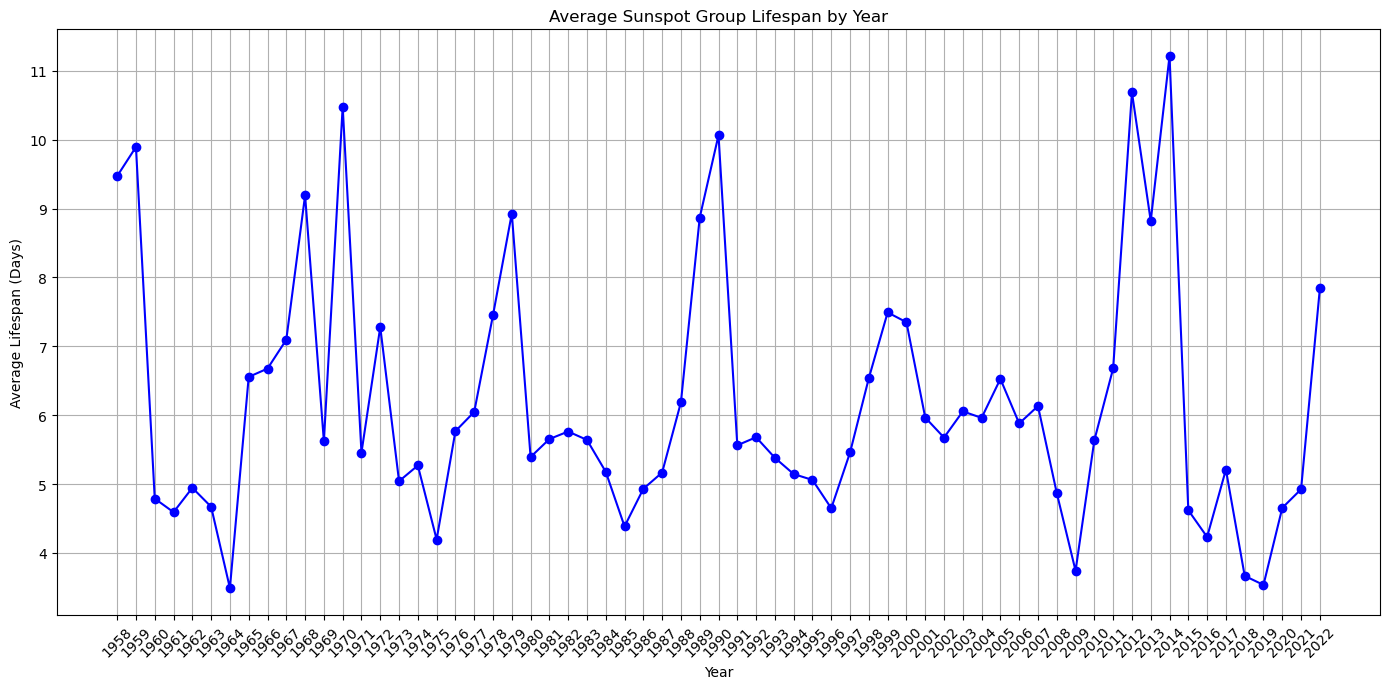

In [6]:
# Convert the years in average_lifespan_by_year to strings
average_lifespan_by_year_str = {str(year): value for year, value in average_lifespan_by_year.items()}

list_of_years = ['1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', 
                 '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', 
                 '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', 
                 '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', 
                 '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', 
                 '2018','2019','2020','2021','2022']

# Initialize a list with values corresponding to list_of_new_years
life_span_values_list = []
for year in list_of_years:
    if year in average_lifespan_by_year_str:
        life_span_values_list.append(average_lifespan_by_year_str[year])
    else:
        life_span_values_list.append(0)
        
# Plotting the data
plt.figure(figsize=(14, 7))
plt.plot(list_of_years, life_span_values_list, marker='o', linestyle='-', color='b')
plt.title('Average Sunspot Group Lifespan by Year')
plt.xlabel('Year')
plt.ylabel('Average Lifespan (Days)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('linegraph_specola_avg_group_lifespan_by_year.png')
plt.show()

In [7]:
######################################## FENYII DATABASE #############################################

In [8]:
# this list contatins the years where we want to gather the data
list_of_years = ['1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

In [9]:
def retrieve_and_process_data(year):
    
    url = f"http://fenyi.solarobs.epss.hun-ren.hu/ftp/pub/DPD/data/DPD{year}.txt"
    
    response = requests.get(url)

    if response.status_code == 200:
        content = response.text
        lines = content.splitlines()

        group_dates = {}

        for line in lines:
            if line.startswith('g'):
                columns = line.split()
                
                # Extract the group number (it's in the 7th position after removing whitespaces)
                group_number = columns[7]
                
                try:
                    int_conversion_of_group_number = int(group_number)
                except ValueError:
                    continue

                # Construct the date from the year, month, and day in the line
                date_str = f"{columns[1]}-{columns[2]}-{columns[3]}"
                date_obj = datetime.strptime(date_str, '%Y-%m-%d')

                # If the group number is not in the dictionary, add it with an empty list
                if group_number not in group_dates:
                    group_dates[group_number] = []

                # Append the date to the list for this group number
                group_dates[group_number].append(date_obj)
                
        last_two_months_groups = {group: dates for group, dates in group_dates.items() if any(d.month >= 11 for d in dates)}
        
        # Load data from the next year to check for overlaps
        next_year = int(year) + 1
        nextt_year = str(next_year)
        
        url_next_year = f"http://fenyi.solarobs.epss.hun-ren.hu/ftp/pub/DPD/data/DPD{nextt_year}.txt"
        response_next_year = requests.get(url_next_year)
        
        if response_next_year.status_code == 200:
            content_next_year = response_next_year.text
            lines_next_year = content_next_year.splitlines()

            for line in lines_next_year:
                if line.startswith('g'):
                    columns = line.split()
                    group_number = columns[7]
                    
                    try:
                        int_conversion_of_group_number = int(group_number)
                    except ValueError:
                        continue

                    date_str = f"{columns[1]}-{columns[2]}-{columns[3]}"
                    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
                    
                    # Only consider dates in January and February of the next year
                    if date_obj.month <= 2 and group_number in last_two_months_groups:
                        group_dates[group_number].append(date_obj)
                        
        return group_dates
    else:
        print(f"Failed to retrieve the page. Status code: {response.status_code}")
        return 0

def calculate_group_durations(group_dates):
    group_durations = {}
    
    for group, dates in group_dates.items():
        if dates:
            # Find the duration between the first and last date
            min_date = min(dates)
            max_date = max(dates)
            duration = (max_date - min_date).days + 1  # Including both start and end dates
            
            group_durations[group] = duration

    return group_durations

def find_avg_days_between_all_sunspots(year):
    all_group_dates = {}
    # list with all the sunspot groups and the date they appear
    year_group_dates = retrieve_and_process_data(year)
    if year_group_dates == 0:
        print('exiting because retrive_and_process data returned an error')
        return 0
    all_group_dates.update(year_group_dates)
    
    # Calculate the durations for each group
    group_durations = calculate_group_durations(all_group_dates)
    
    total_days = 0
    total_spots = 0
    for group, days in list(group_durations.items()):
        total_days += int(days)
        total_spots += 1
    all_group_dates = {}
    return total_days/total_spots

In [10]:
all_group_dates = {}

# Retrieve and process data for each year
year_group_dates = retrieve_and_process_data('1974')
all_group_dates.update(year_group_dates)

# Calculate the durations for each group
group_durations = calculate_group_durations(all_group_dates)

# Convert to DataFrame
df = pd.DataFrame(list(group_durations.items()), columns=['Group Number', 'Duration (Days)'])

In [26]:
list_of_average_sunspot_lifespan_per_year = []
min_feny = []
max_feny = []
for year in list_of_years:
    life_span_per_year = find_avg_days_between_all_sunspots(year)
    list_of_average_sunspot_lifespan_per_year.append(round(life_span_per_year, 2))
    print("for the year {} the average life span for a sunspot group was: {}".format(year,round(life_span_per_year, 2)))
    if int(year) in solar_maximum_years:
        max_feny.append(life_span_per_year)
    if int(year) in solar_minimum_years:
        min_feny.append(life_span_per_year)
print(min_feny[0],max_feny[0])

for the year 1974 the average life span for a sunspot group was: 6.92
for the year 1975 the average life span for a sunspot group was: 6.15
for the year 1976 the average life span for a sunspot group was: 7.17
for the year 1977 the average life span for a sunspot group was: 6.16
for the year 1978 the average life span for a sunspot group was: 7.28
for the year 1979 the average life span for a sunspot group was: 7.79
for the year 1980 the average life span for a sunspot group was: 8.35
for the year 1981 the average life span for a sunspot group was: 7.82
for the year 1982 the average life span for a sunspot group was: 8.11
for the year 1983 the average life span for a sunspot group was: 8.0
for the year 1984 the average life span for a sunspot group was: 6.82
for the year 1985 the average life span for a sunspot group was: 6.68
for the year 1986 the average life span for a sunspot group was: 7.12
for the year 1987 the average life span for a sunspot group was: 6.23
for the year 1988 the

In [11]:
##################################### DUAL ANALYSIS FROM BOTH DATABASES ##################################################################

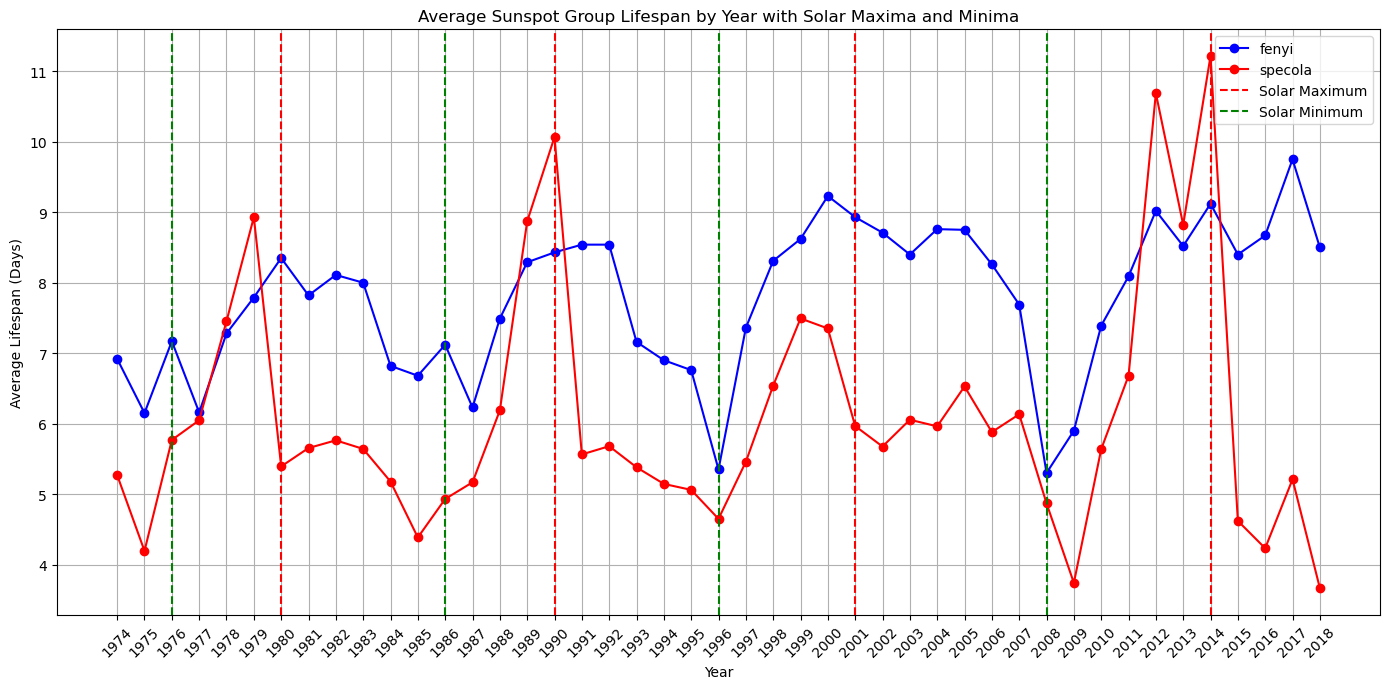

In [24]:
# List of solar maximum and minimum years (example)
solar_maximum_years = ['1980', '1990', '2001', '2014']
solar_minimum_years = ['1976', '1986', '1996', '2008']

# Convert the years in average_lifespan_by_year to strings
average_lifespan_by_year_str = {str(year): value for year, value in average_lifespan_by_year.items()}

# Initialize the test list with values corresponding to list_of_new_years
test = []
for year in list_of_years:
    if year in average_lifespan_by_year_str:
        test.append(average_lifespan_by_year_str[year])
    else:
        test.append(0)  # Append 0 or NaN if there's no data for that year

# Plot both datasets on the same figure
plt.figure(figsize=(14, 7))

# Plot the first set of data
plt.plot(list_of_years, list_of_average_sunspot_lifespan_per_year, marker='o', linestyle='-', color='b', label='fenyi')

# Plot the second set of data
plt.plot(list_of_years, test, marker='o', linestyle='-', color='r', label='specola')

# Add dotted lines for solar maximum years (in red)
for max_year in solar_maximum_years:
    plt.axvline(x=max_year, color='red', linestyle='--', label='Solar Maximum' if max_year == solar_maximum_years[0] else '')

# Add dotted lines for solar minimum years (in green)
for min_year in solar_minimum_years:
    plt.axvline(x=min_year, color='green', linestyle='--', label='Solar Minimum' if min_year == solar_minimum_years[0] else '')

# Add title and labels
plt.title('Average Sunspot Group Lifespan by Year with Solar Maxima and Minima')
plt.xlabel('Year')
plt.ylabel('Average Lifespan (Days)')
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

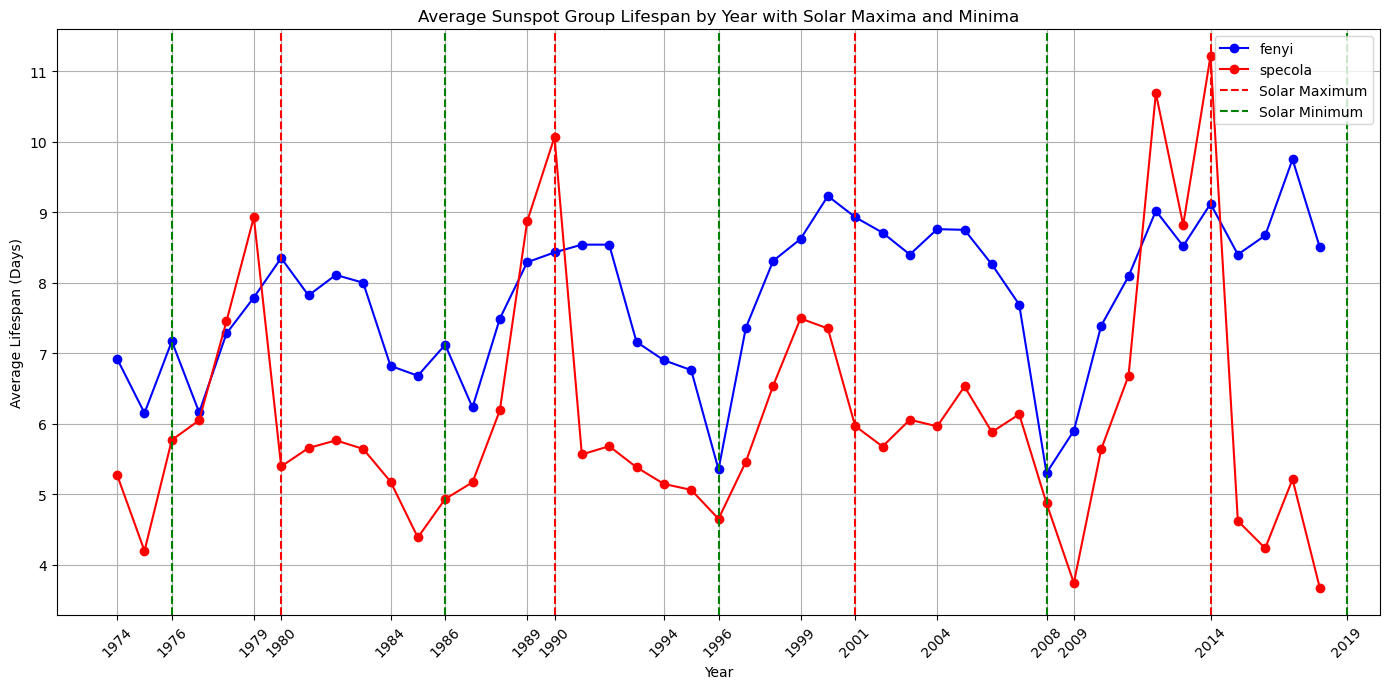

In [13]:
# Generate a list of every 5th year in your dataset
years_to_display = [year for i, year in enumerate(list_of_years) if i % 5 == 0]

# Add solar maximum and minimum years to the list (to ensure they're included)
years_to_display = sorted(set(years_to_display + solar_maximum_years + solar_minimum_years))

# Plot both datasets on the same figure
plt.figure(figsize=(14, 7))

# Plot the first set of data
plt.plot(list_of_years, list_of_average_sunspot_lifespan_per_year, marker='o', linestyle='-', color='b', label='fenyi')

# Plot the second set of data
plt.plot(list_of_years, test, marker='o', linestyle='-', color='r', label='specola')

# Add dotted lines for solar maximum years (in red)
for max_year in solar_maximum_years:
    plt.axvline(x=max_year, color='red', linestyle='--', label='Solar Maximum' if max_year == solar_maximum_years[0] else '')

# Add dotted lines for solar minimum years (in green)
for min_year in solar_minimum_years:
    plt.axvline(x=min_year, color='green', linestyle='--', label='Solar Minimum' if min_year == solar_minimum_years[0] else '')

# Customize x-axis ticks to show every 5th year and solar min/max years
plt.xticks(years_to_display, rotation=45)

# Add title and labels
plt.title('Average Sunspot Group Lifespan by Year with Solar Maxima and Minima')
plt.xlabel('Year')
plt.ylabel('Average Lifespan (Days)')
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


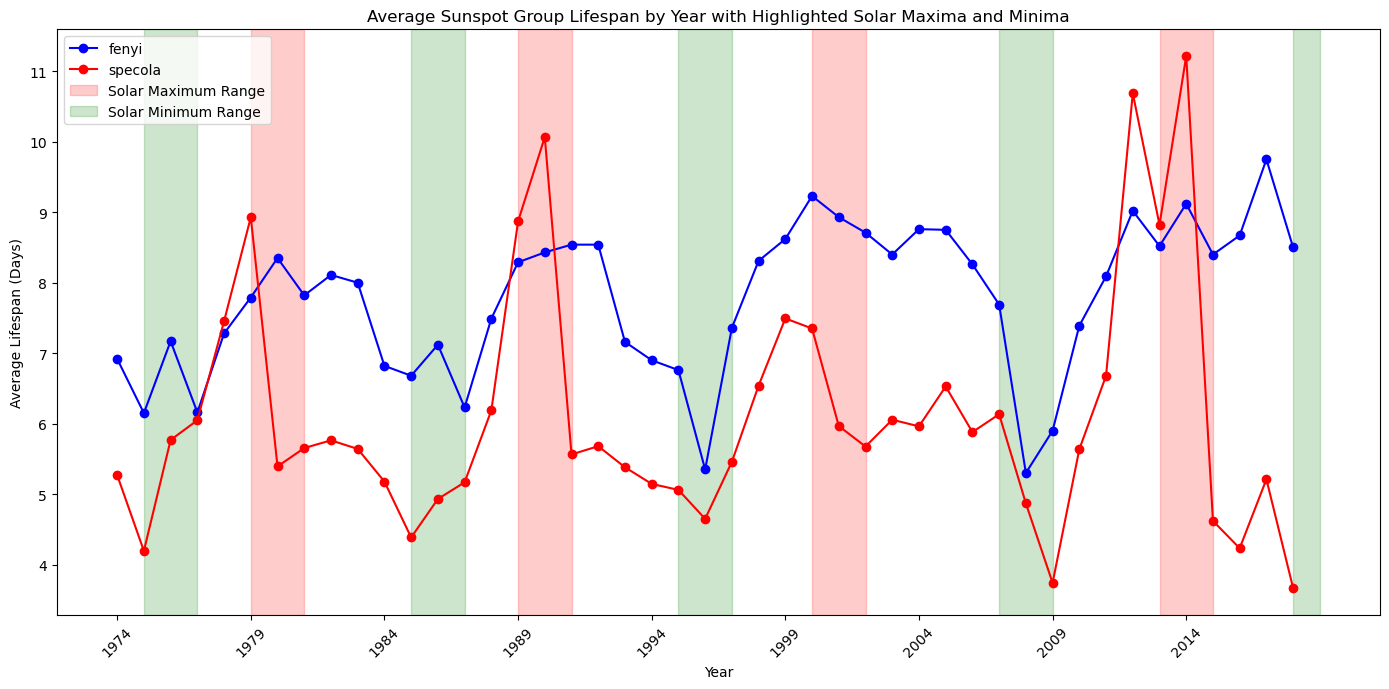

In [22]:
# Convert solar maximum and minimum years to ranges
solar_maximum_ranges = [(int(max_year) - 1, int(max_year) + 1) for max_year in solar_maximum_years]
solar_minimum_ranges = [(int(min_year) - 1, int(min_year) + 1) for min_year in solar_minimum_years]

# Plot both datasets on the same figure
plt.figure(figsize=(14, 7))

# Plot the first set of data
plt.plot(list_of_years, list_of_average_sunspot_lifespan_per_year, marker='o', linestyle='-', color='b', label='fenyi')

# Plot the second set of data
plt.plot(list_of_years, test, marker='o', linestyle='-', color='r', label='specola')

# Highlight solar maximum ranges (in light red)
for start, end in solar_maximum_ranges:
    plt.axvspan(str(start), str(end), color='red', alpha=0.2, label='Solar Maximum Range' if start == int(solar_maximum_years[0]) - 1 else '')

# Highlight solar minimum ranges (in light green)
for start, end in solar_minimum_ranges:
    plt.axvspan(str(start), str(end), color='green', alpha=0.2, label='Solar Minimum Range' if start == int(solar_minimum_years[0]) - 1 else '')

# Add title and labels
plt.title('Average Sunspot Group Lifespan by Year with Highlighted Solar Maxima and Minima')
plt.xlabel('Year')
plt.ylabel('Average Lifespan (Days)')
# plt.grid(True)

# Customize x-axis ticks to show every 5th year and solar min/max years
years_to_display = [year for i, year in enumerate(list_of_years) if i % 5 == 0]
plt.xticks(years_to_display, rotation=45, )

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [28]:
avg_max_specola = sum(test_max) / len(test_max)
print(avg_max_specola)
avg_min_specola = sum(test_min) / len(test_min)
print(avg_min_specola)

8.160898311500135
4.750840368473006


In [29]:
avg_max_feny = sum(max_feny) / len(max_feny)
print(avg_max_feny)
avg_min_feny = sum(min_feny) / len(min_feny)
print(avg_min_feny)

8.707577171527305
6.2336425479282624


In [30]:
print(avg_max_specola - avg_max_feny)

-0.5466788600271695
